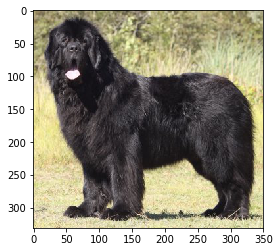

In [33]:
import os
import numpy as np
import tensorflow as tf
import scipy as sp
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt
from datetime import datetime

test_data = scipy.ndimage.imread('./newfie-test.jpeg',mode='RGB')

plt.imshow(test_data)

plt.show()

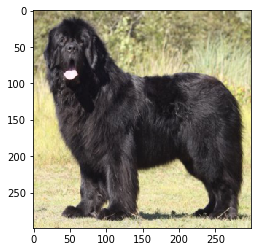

In [34]:
newfie_test_data = scipy.misc.imresize(test_data,size=(299,299,3))


plt.imshow(newfie_test_data)

plt.show()

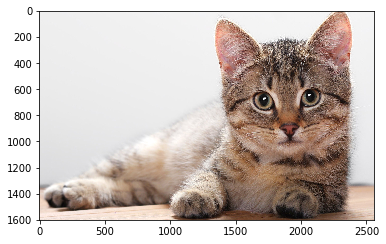

In [35]:
test_data = scipy.ndimage.imread('./kitten-test.jpeg',mode='RGB')

plt.imshow(test_data)

plt.show()

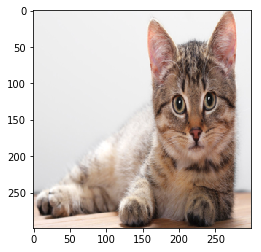

In [36]:
kitten_test_data = scipy.misc.imresize(test_data,size=(299,299,3))

plt.imshow(kitten_test_data)

plt.show()

In [37]:
newfie_test_data = np.expand_dims(newfie_test_data,0)
kitten_test_data = np.expand_dims(kitten_test_data,0)

full_img_array = np.zeros((3,4,299,299,3))

img_array1 = np.concatenate([newfie_test_data,kitten_test_data,newfie_test_data,newfie_test_data])

print(kitten_test_data.shape)
print(img_array1.shape)

full_img_array[0,:,:,:,:] = img_array1
full_img_array[1,0,:,:,:] = kitten_test_data
full_img_array[1,1,:,:,:] = newfie_test_data
full_img_array[2,0,:,:,:] = newfie_test_data
full_img_array[2,1,:,:,:] = newfie_test_data
full_img_array[2,2,:,:,:] = kitten_test_data

print(full_img_array.shape)

clip_lens = np.array([4,2,3]).reshape((3,1))
clip_labels = np.array([1,2,3])
print(clip_lens.shape)

(1, 299, 299, 3)
(4, 299, 299, 3)
(3, 4, 299, 299, 3)
(3, 1)


In [54]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}".format(root_logdir, now)
    
reset_graph()

batch_size = 256
max_clip_len = 4
num_epochs = 1000
learn_rate = 0.01

from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
checkpoint_path = "/Users/mayhew5/Desktop/Projects/Deep-Thoughts/spatioTempNet/inception-v3/model.ckpt-157585"

print_tensors_in_checkpoint_file(file_name=checkpoint_path,tensor_name='weights',all_tensors=False)

# read in InceptionV3
#inceptionDir = '/p/lscratche/kim63/imgnet_inception_v3'
inception_dir = './'

# adapted from Hyojin's code
def loadInceptionV3(model_path):
    with tf.gfile.FastGFile(model_path, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

    return [n.name for n in tf.get_default_graph().as_graph_def().node]

inception_path = os.path.join(inception_dir, 'classify_image_graph_def.pb')
incept_layer_names = loadInceptionV3(inception_path)

graph_def = tf.get_default_graph().as_graph_def()

new_graph = tf.Graph()

with new_graph.as_default():
    #X = tf.placeholder(tf.uint8,shape=(299,299,3),name="X")
    
    #pool3_tensor = tf.import_graph_def(graph_def,input_map={'DecodeJpeg:0': X},return_elements=['pool_3/_reshape:0'])
    #pool3_flat = tf.squeeze(pool3_tensor)
    
    C = tf.placeholder(tf.uint8,shape=(None,max_clip_len,299,299,3),name="C")

# fully_connected(
#    inputs,
#    num_outputs,
#    activation_fn=tf.nn.relu,
#    normalizer_fn=None,
#    normalizer_params=None,
#    weights_initializer=initializers.xavier_initializer(),
#    weights_regularizer=None,
#    biases_initializer=tf.zeros_initializer(),
#    biases_regularizer=None,
#    reuse=None,
#    variables_collections=None,
#    outputs_collections=None,
#    trainable=True,
#    scope=None
#)

    embed_W = tf.Variable(tf.random_uniform([2048,300],-1.0,1.0,seed=42),name="embed_W")
    embed_b = tf.Variable(tf.random_uniform([1,300],-1.0,1.0,seed=42),name="embed_b")
    shape_tensor = tf.placeholder(tf.uint8,shape=(None,1),name="shape_tensor")
    
    def frame_feat_transform(X):
        pool3_tensor = tf.import_graph_def(graph_def,input_map={'DecodeJpeg:0': X},return_elements=['pool_3/_reshape:0'])
        return(pool3_tensor[0])
    
    def frame_feat_embed(X):
        #embed_pool3 = tf.contrib.layers.fully_connected(X,num_outputs=300,weights_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-05),biases_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-05))
        embed_pool3 = tf.nn.relu(tf.add(embed_b,tf.matmul(X,embed_W)))
        return(embed_pool3[0])
    
    def clip_batch_feats(X):
        # X is a clip here - so must map_fn on batch of clips
        frame_feats = tf.map_fn(frame_feat_transform, X, dtype=tf.float32,infer_shape=False,name="map_frame_feats")
        frame_feat_embeddings = tf.map_fn(frame_feat_embed, frame_feats, dtype=tf.float32, infer_shape=False, name="map_feat_embed")
        return(frame_feat_embeddings)

    with tf.variable_scope("import") as scope:
        scope.reuse_variables()
    
    #frame_feats = tf.map_fn(frame_feat_transform, C, dtype=tf.float32,infer_shape=False,name="map_frame_feats")
    #frame_feat_embeddings = tf.map_fn(frame_feat_embed, frame_feats, dtype=tf.float32,infer_shape=False,name="map_feat_embed")
    
    clip_batch_embeddings = tf.map_fn(clip_batch_feats, C, dtype=tf.float32,infer_shape=False,name="map_clip_embed")
    
    #max_merge = lambda x : np.ndarray.max(x,0)
    def tensor_split(clip_len,num_splits,embed_dim):
        split_starts = []
        split_ends = []
        if num_splits == 1:
            split_starts.append([0,0])
            split_ends.append(tf.concat([tf.slice(clip_len,[0],[1]),[embed_dim]],axis=0))
        return(tf.expand_dims(tf.concat(split_starts,axis=0),axis=0),tf.expand_dims(tf.concat(split_ends,axis=0),axis=0))
    
    # temporal pyramid pooling layer
    def temporal_pyramid_pooling(input_clip,depth=3,splits=[1]):
        # expects feat_seq to be a numpy array of inception-v3 feature vectors for each frame in a clip
        # with leading dimension being the number of frames

        print(input_clip[0])
        #print(input_clip.shape)
    
        tens_list = []
        for split in splits:
            split_starts, split_ends = tensor_split(input_clip[1],1,300)
            print(split_starts)
            print(split_ends)
            i = tf.constant(0)
            loop_cond = lambda i: tf.less(i, split_starts.shape[0])
            print(split_starts.shape[0])
            def loop_body(i):
                #tens_list.append(tf.reduce_max(tf.slice(input_clip[0],tf.slice(split_starts,[i,i],[1,1]),tf.slice(split_ends,[i,i],[1,1]),axis=0)))
                print(split_starts)
                print(tf.slice(split_starts,[i],[1,1]))
                tens_list.append(tf.reduce_max(tf.slice(input_clip[0],split_starts[i],split_ends[i])))
                tf.add(i, 1)
            r = tf.while_loop(loop_cond, loop_body, [i])     

        #for split in splits:
            # divide feat_seq into 'split' equal parts
            #split_idxs = np.array_split(xrange(input_clip[1][0]),split)
            #print(split_idxs)
#            for split_idx in split_idxs:
#                print(split_idx)
                #tens_list.append([merge_op(feat_split) for feat_split in feat_splits])

        test = tf.concat(tens_list)
        print(test)
        print(test.shape)
    
        return(tf.reduce_max(tf.slice(input_clip[0],[0,0],[2,300]),axis=0))
    
    temp_pyramid_pool_feats = tf.map_fn(temporal_pyramid_pooling,[clip_batch_embeddings,shape_tensor],dtype=tf.float32,infer_shape=False,name="temp_pyramid_pool")
    
file_writer = tf.summary.FileWriter(logdir, new_graph)

embed_init = tf.variables_initializer([embed_W,embed_b])

with tf.Session(graph=new_graph) as sess:
    sess.run(embed_init)
    #out_results = sess.run(frame_feat_embeddings,feed_dict={'C:0': img_array})
    out_results = sess.run(temp_pyramid_pool_feats,feed_dict={'C:0': full_img_array,'shape_tensor:0':clip_lens})
    print(out_results.shape)
    print(out_results)
    
for n in new_graph.as_graph_def().node:
    print n.name

tensor_name:  weights
weights not found in checkpoint file
Tensor("temp_pyramid_pool/while/TensorArrayReadV3:0", dtype=float32)
Tensor("temp_pyramid_pool/while/ExpandDims:0", shape=(1, 2), dtype=int32)
Tensor("temp_pyramid_pool/while/ExpandDims_1:0", shape=(1, 2), dtype=uint8)
1
Tensor("temp_pyramid_pool/while/ExpandDims:0", shape=(1, 2), dtype=int32)


ValueError: Dimension 0 in both shapes must be equal, but are 1 and 2 for 'temp_pyramid_pool/while/while/Slice' (op: 'Slice') with input shapes: [1,2], [1], [2].

In [8]:
test_array = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(test_array.shape)

test_array2 = np.split(test_array,test_array.shape[0])
print(test_array2)

(3, 3)
[array([[1, 2, 3]]), array([[4, 5, 6]]), array([[7, 8, 9]])]


In [162]:
tf.reset_default_graph()

#X = tf.placeholder(tf.float32, shape=(None,299,299,3),name="X")
X = tf.placeholder(tf.float32, shape=(None,1,3),name="X")

def test_func(x):
    print(x.shape)
    return([x,x])

out_test = tf.map_fn(test_func, X,dtype=[tf.float32,tf.float32])

with tf.Session() as sess:
    out_result = sess.run(out_test,{'X:0':test_array2})
    print(out_result)

(1, 3)
[array([[[ 1.,  2.,  3.]],

       [[ 4.,  5.,  6.]],

       [[ 7.,  8.,  9.]]], dtype=float32), array([[[ 1.,  2.,  3.]],

       [[ 4.,  5.,  6.]],

       [[ 7.,  8.,  9.]]], dtype=float32)]


In [ ]:
## read in clip data
mpii_root_dir = '/p/lscratche/brainusr/datasets/deep_thoughts/mpii-cooking/'
frame_dir = mpii_root_dir + 'frames-for-inception/'

train_subjs = ['s08','s10','s16','s17','s18','s19','s20']
test_subjs = ['s11','s12','s13','s14','s15']

# filter training and test ground truth lines
with open(mpii_root_dir + 'detectionGroundtruth-1-0.csv','r') as ground_truth:
    ground_truth_samples = [line.strip.split(',') for line in ground_truth.readlines()]
    train_clips = [ground_sample for ground_sample in ground_truth_samples if ((ground_sample[1][:3] in train_subjs) and (ground_sample[5].find("Background") == -1))]
    test_clips = [ground_sample for ground_sample in ground_truth_samples if ((ground_sample[1][:3] in train_subjs) and (ground_sample[5].find("Background") == -1))]

In [ ]:
def fetch_triplet_batch(batch_idx,batch_size):
    